# Notebook to run NASCAR analysis part 1: component selection

In [1]:
from scipy.io import loadmat
from scipy.stats import ttest_ind

from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import fft
import seaborn as sns
import pandas as pd
from scipy import signal

def andrew_welch(Ut):
    wlen = 100
    win = signal.windows.hamming(wlen)
    ovlp = 0.75
    Fs = 1/0.8
    f, pxx = signal.welch(Ut, fs=Fs, window=win, nperseg=wlen, noverlap=int(wlen*ovlp))
    return f, pxx

## Choose task, Load data from matlab

In [2]:
#task='movieTP'
task='rest_run-1'
task='movieDM'
task='movieTP'

bad_components_list=[]

In [3]:
outputs_file=f'../data/nascar_output/all_ses-HBNsiteRU_task-{task}_results.mat'
gbs_file=f'../data/nascar_output/all_ses-HBNsiteRU_task-{task}_GBS.mat'
mat_contents = loadmat(outputs_file)
U2=mat_contents['U2']
lambda2=mat_contents['lambda2']
mat_contents = loadmat(gbs_file)
Y=mat_contents['Y']
O=mat_contents['O']
components=U2[0][0]
temporal_modes=U2[1][0]
contributions=U2[2][0]
print(task)
print('O',O.shape, '       #orthogonal transformation matrix TxTxS')
print('Y',Y.shape, '       #group atlas TxV')
print('components', components.shape)
print('temporal_modes',temporal_modes.shape)
print('contributions',contributions.shape)
print('lambda2',lambda2.shape)
#result = np.dot(temporal_modes[:,0], O[:,:,0].T)

movieTP
O (240, 240, 217)        #orthogonal transformation matrix TxTxS
Y (240, 91282)        #group atlas TxV
components (91282, 30)
temporal_modes (240, 30)
contributions (217, 30)
lambda2 (30, 1)


## plot the spectrum of the temporal components to see which are noise

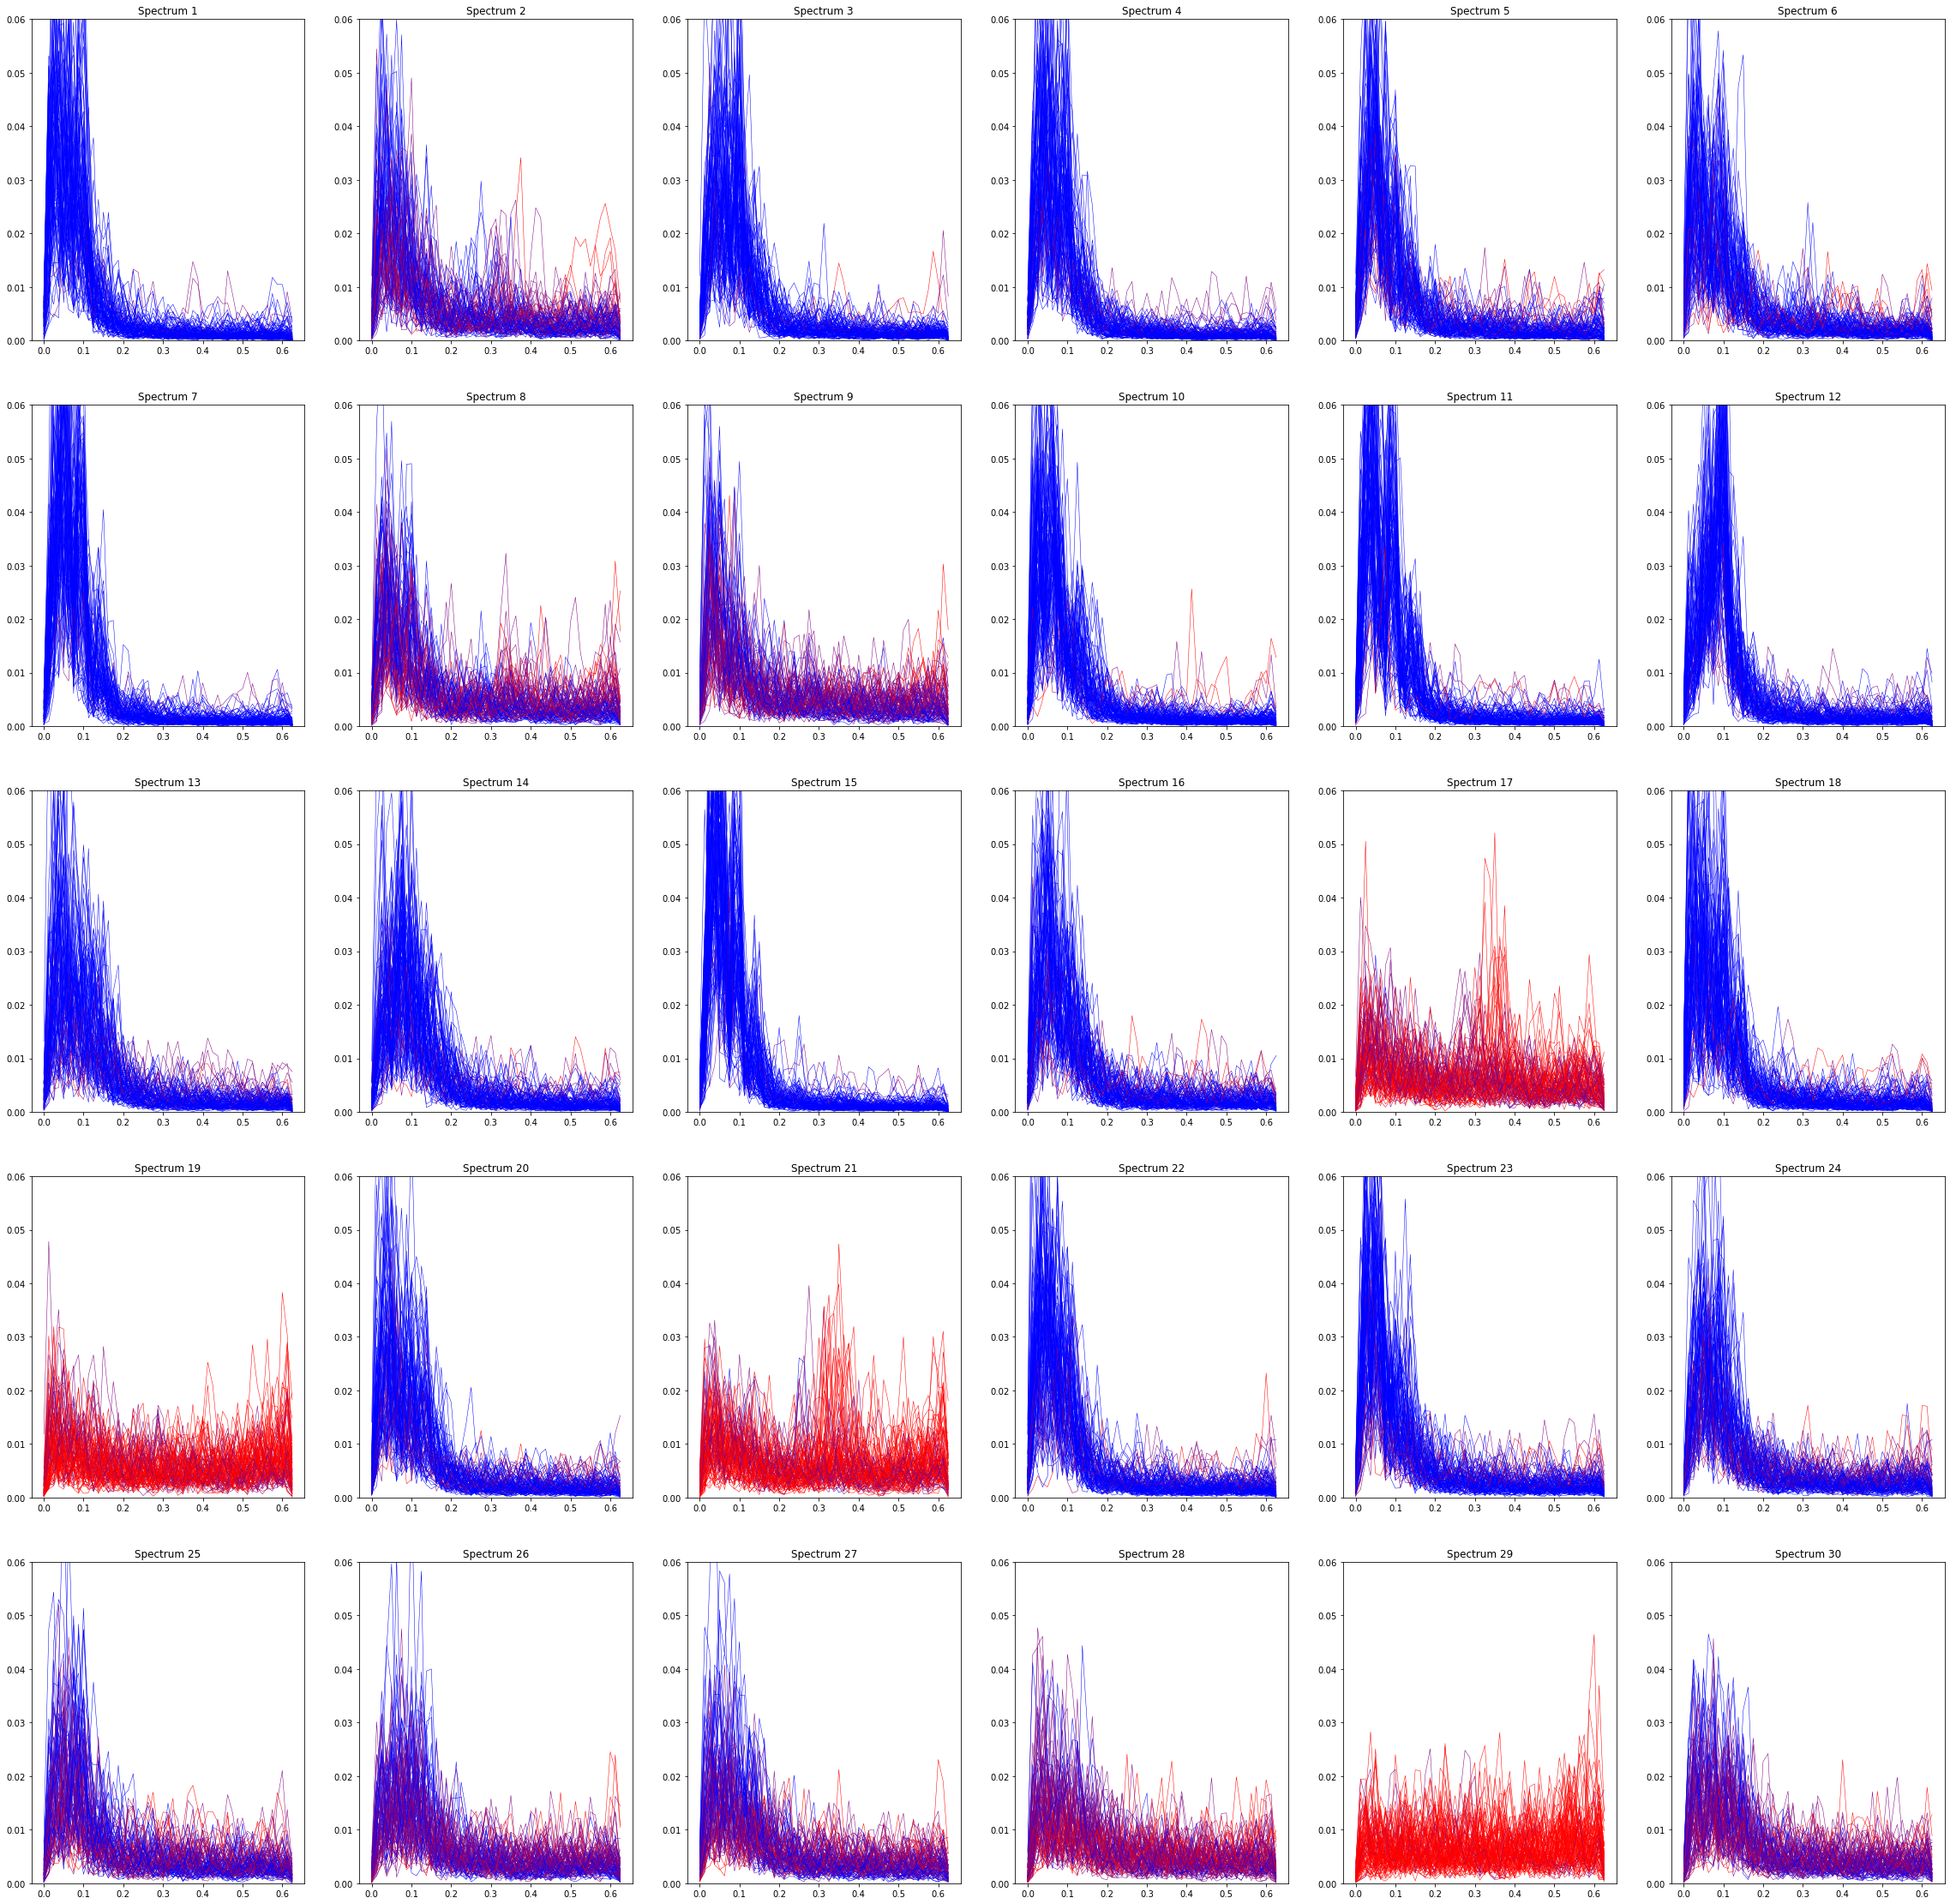

In [5]:
temporal_node_l,temporal_node_n =temporal_modes.shape

fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(40, 40))

#for rest:
thresh1=0.05
thresh2=0.15
ylim=0.06

# #for movieDM:
# thresh1=0.05
# thresh2=0.08
# ylim=0.03

for n in np.arange(temporal_node_n):
    axs[n // 6, n % 6].set_title(f"Spectrum {n+1}")
    axs[n // 6, n % 6].set_ylim([0, ylim])
    for nn in np.arange(100):
        s = np.dot(temporal_modes[:,n], O[:,:,nn])

        f, pxx=andrew_welch(s)

    #     dt = 0.8  # sampling interval
    #     Fs = 1 / dt  # sampling frequency
    #     t = np.arange(0, dt*temporal_node_l, dt)

    #     # plot different spectrum types:
    #     axs[n // 6, n % 6].set_title(f"Magnitude Spectrum {n+1}")
    #     axs[n // 6, n % 6].magnitude_spectrum(s, Fs=Fs,color='C1')

        score=pxx[:25].sum()-pxx[25:].sum()

        if score>thresh2:
            c='b'
        elif score>thresh1:
            c='purple'
        else:
            c='r'
        axs[n // 6, n % 6].plot(f,pxx,c=c,linewidth=0.5)
        #axs[n // 6, n % 6].text(0, 0, f'{score}', fontsize=12)

In [5]:
bad_components_list.extend([3,10,11,16,19,24,26,27,28,29,30])
bad_components_list

[3, 10, 11, 16, 19, 24, 26, 27, 28, 29, 30]

## look at the contributions to see if some are heavily weighted by some subjects

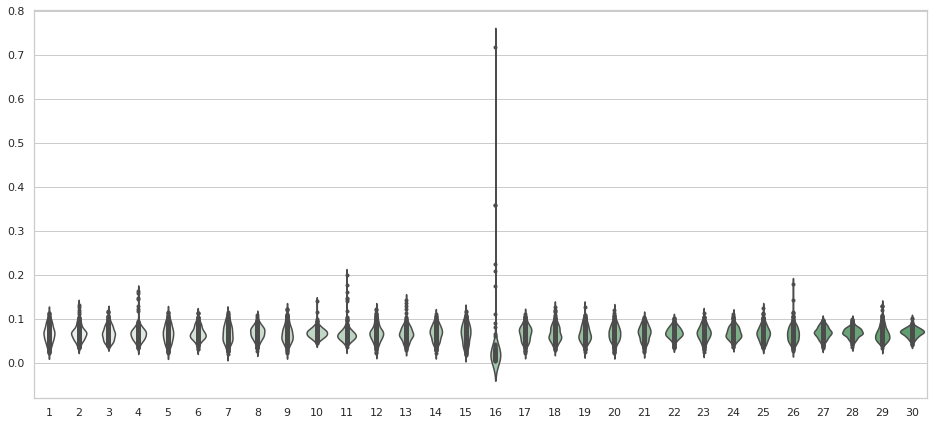

In [6]:
sns.set_theme()
plt.rcParams['figure.dpi'] = 72
plt.rcParams['savefig.dpi'] = 72
plt.figure(figsize=(16,7))

sns.set_theme(style="whitegrid")
sns.violinplot(data=contributions, palette="light:g", inner="points", orient="v")

tick_positions = range(30);
tick_labels = [str(i+1) for i in tick_positions];
plt.xticks(ticks=tick_positions, labels=tick_labels);

In [7]:
bad_components_list.extend([16])
bad_components_list

[3, 10, 11, 16, 19, 24, 26, 27, 28, 29, 30, 16]

## look at the brain images and discard any physiologically implausible

In [8]:
bad_components_list.extend([11,16])

In [9]:
bad_components_list=list(set(bad_components_list))
bad_components_list

[3, 10, 11, 16, 19, 24, 26, 27, 28, 29, 30]

In [10]:
good_components=list(range(1,31))
good_components = [x for x in good_components if x not in bad_components_list]
print(good_components)
print(len(good_components))

[1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 25]
19


In [11]:
good_components_file=f'../data/nascar_output/all_ses-HBNsiteRU_task-{task}_good_components.txt'

with open(f'{good_components_file}', 'w') as f:
    # write the contents of the list to the file
    for item in good_components:
        f.write(f"{item}\n")

## look at the contributions by diagnosis to see if ASD or TD is better represented

In [98]:
meta=pd.read_csv('../data/for_matlab/old_all_ses-HBNsiteRU_task-rest_run-1.csv')

In [99]:
meta_dx_list=meta['dx'].tolist()

dx_list = [0 if x == 'ndg' else 1 if x == 'asd' else x for x in meta_dx_list]

asc_ind=np.nonzero(dx_list)[0]
td_ind=indices = [i for i, x in enumerate(dx_list) if x == 0]

t_list=[]
p_list=[]
for i in np.arange( contributions.shape[1] ):
    asc_contributions = contributions[:,i][asc_ind]
    td_contributions = contributions[:,i][td_ind]
    t,p=ttest_ind(asc_contributions, td_contributions)
    t_list.append(t)
    p_list.append(p)

In [100]:
column_list=[]
for i in np.arange(30):
    column_list.append(f'component{i+1}')
# df = pd.DataFrame(contributions_rest, columns=column_list)
arr_df = pd.DataFrame(contributions, columns=['component{}'.format(i+1) for i in range(30)])

# Concatenate the two DataFrames along the columns axis
df = pd.concat([meta, arr_df], axis=1)

df=pd.melt(df, id_vars=['subject','dx','age'], value_vars=column_list, var_name='component', value_name='contribution')


[Text(0.5, 1.0, 'Individual Contributions to each Component by Diagnostic Status')]

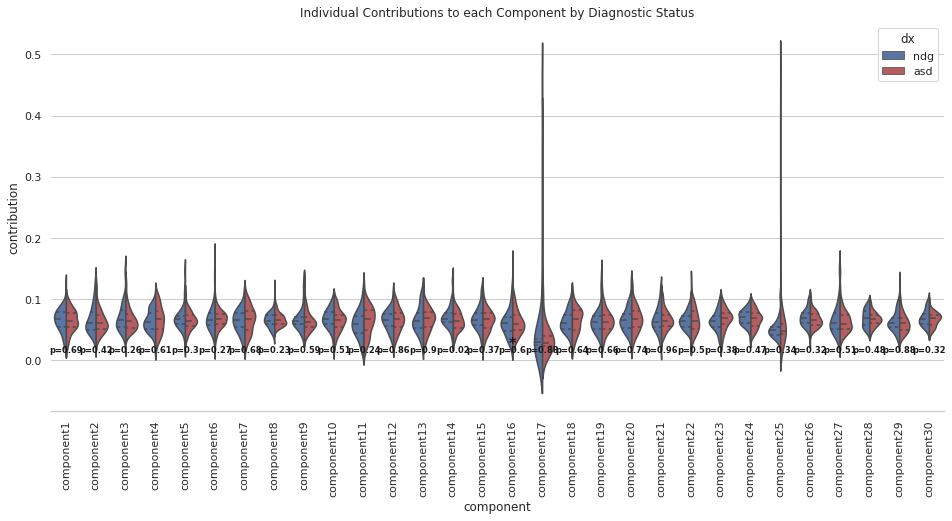

In [101]:
plt.rcParams['figure.dpi'] = 72
plt.rcParams['savefig.dpi'] = 72
plt.figure(figsize=(16,7))

sns.set_theme(style="whitegrid")
#sns.set(font_scale=2)
# Draw a nested violinplot and split the violins for easier comparison
violinplot=sns.violinplot(data=df, x="component", y="contribution", hue="dx",
               split=True, inner="quart", linewidth=1.5, palette={"ndg": "b", "asd": "r"})
sns.despine(left=True)
plt.xticks(rotation=90)


#p_values = df.groupby(['component'])['contribution'].median()
vertical_offset = df['contribution'].median() * 0.05 # offset from median for display

for xtick in violinplot.get_xticks():
    violinplot.text(xtick,0.01 + vertical_offset, f'p={round(p_list[xtick],2)}', 
            horizontalalignment='center',size='x-small',color='k',weight='semibold')
xtick=15
violinplot.text(xtick,0.02 + vertical_offset, f'*', 
            horizontalalignment='center',size='large',color='k',weight='semibold')

violinplot.set(title='Individual Contributions to each Component by Diagnostic Status')